# Thesis - EDA
Eduardo Tomasi Kruel

https://github.com/eduardokruel/mscthesis

#### Dataset MuSiQue


In [27]:
# Import required libraries
import json
import pandas as pd
from typing import List, Dict, Any, Set
import numpy as np
from dotenv import load_dotenv
import os
from openai import OpenAI
from time import sleep

# Function to load JSONL file
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the development set
dev_data = load_jsonl('datasets/musique/musique_full_v1.0_train.jsonl')

# Create a DataFrame for better visualization
df = pd.DataFrame(dev_data)

# Display basic information about the dataset
print("Dataset size:", len(df))
print("\nColumns:", df.columns.tolist())

# Basic analysis of paragraphs
def analyze_paragraphs(row):
    return {
        'num_paragraphs': len(row['paragraphs']),
        'supporting_paragraphs': sum(1 for p in row['paragraphs'] if p.get('is_supporting', False))
    }

paragraph_stats = df.apply(analyze_paragraphs, axis=1)
paragraph_stats_df = pd.DataFrame(paragraph_stats.tolist())

print("\nParagraph Statistics:")
print("Average number of paragraphs per example:", paragraph_stats_df['num_paragraphs'].mean())
print("Average number of supporting paragraphs:", paragraph_stats_df['supporting_paragraphs'].mean())
print("Number of answerable examples:", df['answerable'].value_counts())



Dataset size: 39876

Columns: ['id', 'paragraphs', 'question', 'question_decomposition', 'answer', 'answer_aliases', 'answerable']

Paragraph Statistics:
Average number of paragraphs per example: 19.99731668171331
Average number of supporting paragraphs: 1.6020914835991573
Number of answerable examples: answerable
False    19938
True     19938
Name: count, dtype: int64


In [28]:
df.head()

id                                         paragraphs  \
0    2hop__42543_20093  [{'idx': 0, 'title': 'All Things in Time', 'pa...   
1  2hop__269805_135710  [{'idx': 0, 'title': 'Milton F. Pavlic', 'para...   
2  2hop__568389_161223  [{'idx': 0, 'title': 'Bugabula', 'paragraph_te...   
3   2hop__131693_45439  [{'idx': 0, 'title': 'United States Declaratio...   
4  2hop__150985_444333  [{'idx': 0, 'title': 'Journal of Geographical ...   

                                            question  \
0  What year did the writer of Crazy Little Thing...   
1  What is the country where Nissedal is located ...   
2  What is the highest point in the country where...   
3  Who from the state with the Routzahn-Miller Fa...   
4  Who founded the publisher of Journal of Media ...   

                              question_decomposition            answer  \
0  [{'id': 42543, 'question': 'who wrote crazy li...              1991   
1  [{'id': 269805, 'question': 'Nissedal >> count...             north   
2  [{'id': 568389, 'question': 'Bugabula >> count...      1,400 metres   
3  [{'id': 131693, 'question': 'Which state is Ro...   Charles Carroll   
4  [{'id': 150985, 'question': 'What is the name ...  George Routledge   

  answer_aliases  answerable  
0             []       False  
1     [North, N]        True  
2             []        True  
3             []        True  
4             []       False

In [18]:
paragraph_stats_df.head()

num_paragraphs  supporting_paragraphs
0              20                      0
1              20                      2
2              20                      2
3              20                      2
4              20                      1

In [29]:
# Question length distribution
df['question_length'] = df['question'].str.len()
print("\nQuestion length statistics:")
print(df['question_length'].describe())

# Most common question starters
df['question_starter'] = df['question'].str.split().str[0]
print("\nMost common question starters:")
print(df['question_starter'].value_counts().head())


Question length statistics:
count    39876.000000
mean        89.970759
std         30.745613
min         29.000000
25%         68.000000
50%         83.000000
75%        105.000000
max        283.000000
Name: question_length, dtype: float64

Most common question starters:
question_starter
What    11466
When     7912
Who      7552
In       2728
How      2656
Name: count, dtype: int64


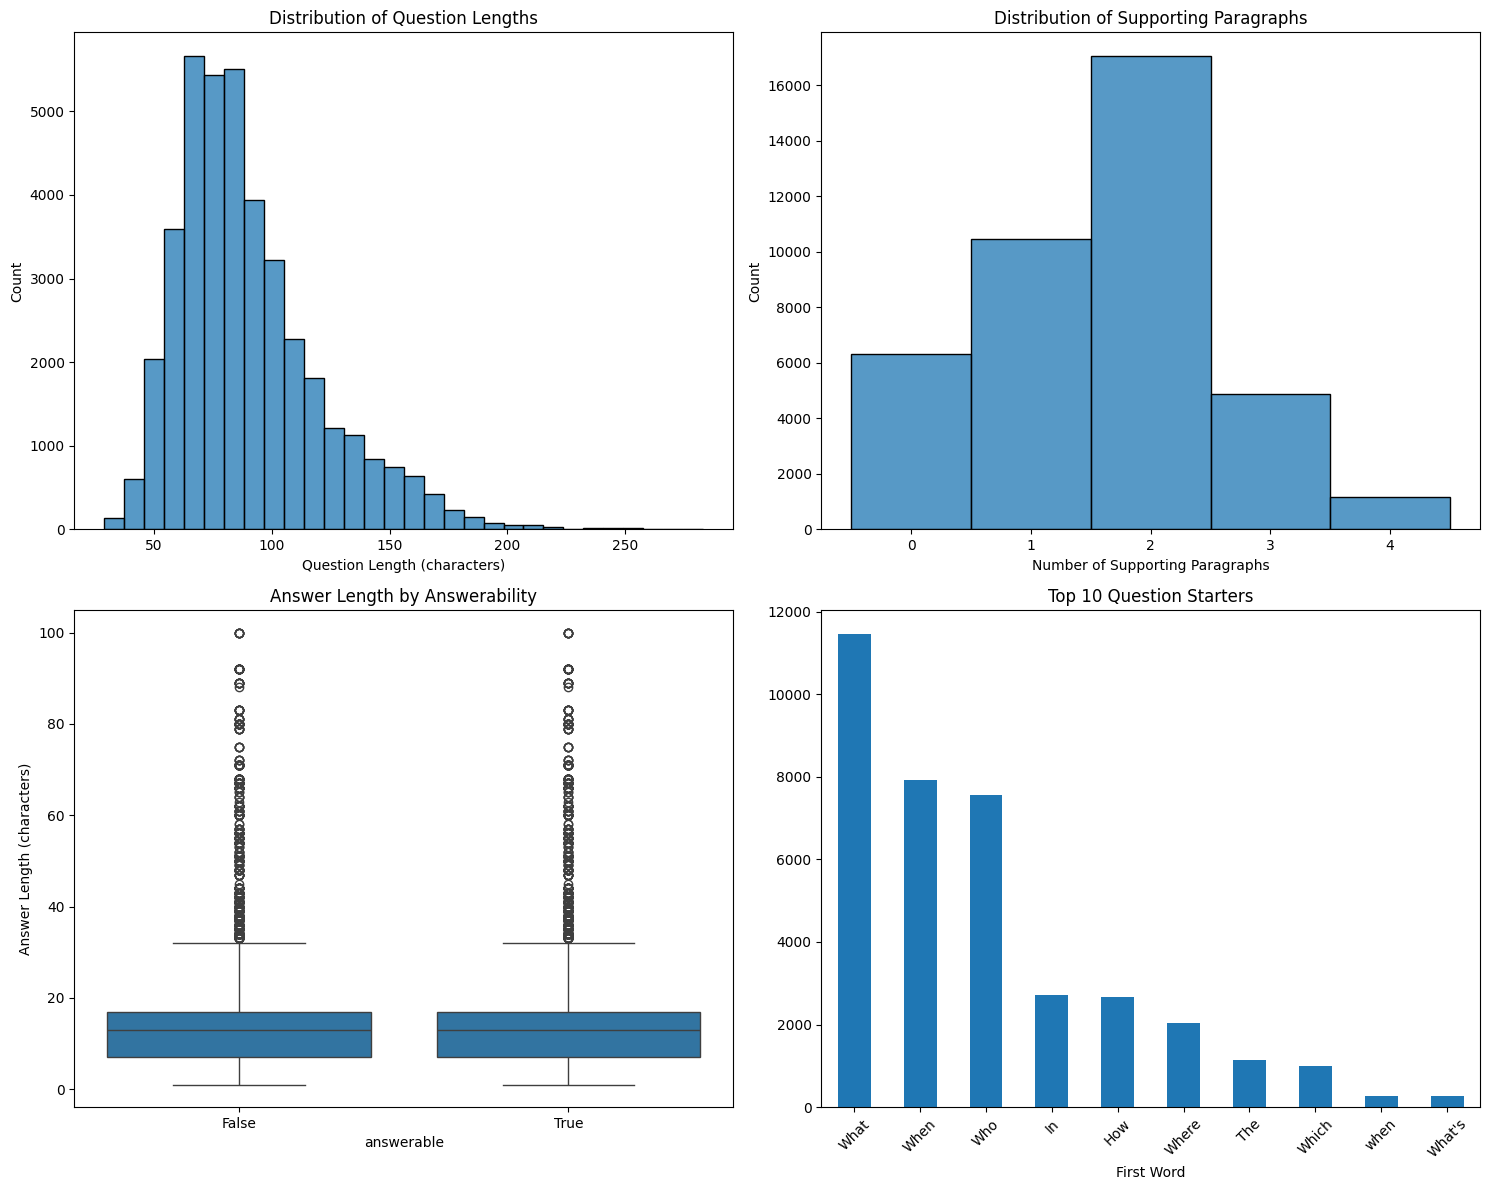

: 

In [35]:
# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Question length distribution
sns.histplot(data=df, x='question_length', bins=30, ax=axes[0,0])
axes[0,0].set_title('Distribution of Question Lengths')
axes[0,0].set_xlabel('Question Length (characters)')

# 2. Supporting paragraphs distribution
sns.histplot(data=paragraph_stats_df, x='supporting_paragraphs', 
            bins=range(0, max(paragraph_stats_df['supporting_paragraphs'])+2), # Integer bins
            discrete=True,  # Treat as discrete values
            ax=axes[0,1])
axes[0,1].set_title('Distribution of Supporting Paragraphs')
axes[0,1].set_xlabel('Number of Supporting Paragraphs')
axes[0,1].set_xticks(range(0, max(paragraph_stats_df['supporting_paragraphs'])+1))


# 3. Answer length analysis
df['answer_length'] = df['answer'].str.len()
sns.boxplot(data=df, x='answerable', y='answer_length', ax=axes[1,0])
axes[1,0].set_title('Answer Length by Answerability')
axes[1,0].set_ylabel('Answer Length (characters)')

# 4. Question starter distribution
question_starters = df['question_starter'].value_counts().head(10)
question_starters.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Top 10 Question Starters')
axes[1,1].set_xlabel('First Word')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [21]:
# Answer analysis
print("\nAnswer length statistics:")
print(df['answer_length'].describe())

# Correlation between question length and number of supporting paragraphs
correlation = df['question_length'].corr(paragraph_stats_df['supporting_paragraphs'])
print(f"\nCorrelation between question length and supporting paragraphs: {correlation:.3f}")

# Question decomposition analysis
df['decomposition_steps'] = df['question_decomposition'].str.len()
print("\nQuestion decomposition statistics:")
print(df['decomposition_steps'].describe())

# Percentage of questions with answer aliases
has_aliases = (df['answer_aliases'].str.len() > 0).mean() * 100
print(f"\nPercentage of questions with answer aliases: {has_aliases:.2f}%")


Answer length statistics:
count    39876.000000
mean        14.745361
std         11.307243
min          1.000000
25%          7.000000
50%         13.000000
75%         17.000000
max        100.000000
Name: answer_length, dtype: float64

Correlation between question length and supporting paragraphs: 0.392

Question decomposition statistics:
count    39876.000000
mean         2.337897
std          0.584463
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: decomposition_steps, dtype: float64

Percentage of questions with answer aliases: 18.09%



Distribution of questions by hop count:
2hop: 28752 questions (72.1%)
3hop: 8774 questions (22.0%)
4hop: 2350 questions (5.9%)


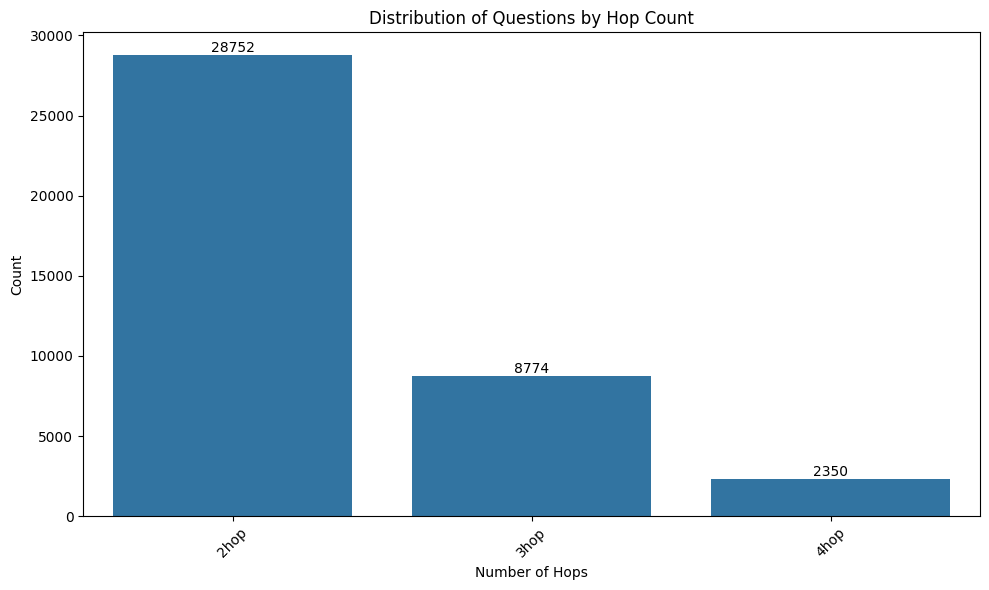

In [25]:
# Extract hop count from id
df['hop_count'] = df['id'].str.extract(r'(\dhop)').fillna('unknown')

# Display counts and percentages
hop_counts = df['hop_count'].value_counts()
hop_percentages = df['hop_count'].value_counts(normalize=True) * 100

print("\nDistribution of questions by hop count:")
for hop, count in hop_counts.items():
    percentage = hop_percentages[hop]
    print(f"{hop}: {count} questions ({percentage:.1f}%)")

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hop_count', order=sorted(df['hop_count'].unique()))
plt.title('Distribution of Questions by Hop Count')
plt.xlabel('Number of Hops')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(hop_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
avg_supporting = df.groupby('hop_count')['answerable'].mean()
print("\nPercentage of answerable questions by hop count:")
for hop, percentage in (avg_supporting * 100).items():
    print(f"{hop}: {percentage:.1f}%")


Percentage of answerable questions by hop count:
2hop: 50.0%
3hop: 50.0%
4hop: 50.0%


#### Pipeline
Most work was done outside of this notebook, but I'll include the sample output here for reference. Code was run in a separate script based on the codebase I am currently developing.

```
Loading dataset...
Loading dataset from: /Users/eduardokruel/GitHub/mscthesis/datasets/musique/musique_full_v1.0_dev.jsonl
Dataset size: 4834

Columns: ['id', 'paragraphs', 'question', 'question_decomposition', 'answer', 'answer_aliases', 'answerable']

Paragraph Statistics:
Average number of paragraphs per example: 19.988829127016963
Average number of supporting paragraphs: 1.8893256102606537
Average number of supporting paragraphs: answerable
False    2417
True     2417
Name: count, dtype: int64
Processing example with ID: 6
id                                                       2hop__169443_83769
paragraphs                [{'idx': 0, 'title': 'My School Daze', 'paragr...
question                  Who did the screenwriter for Good Will Hunting...
question_decomposition    [{'id': 169443, 'question': 'Good Will Hunting...
answer                                                       Fred O'Bannion
answer_aliases                                                           []
answerable                                                             True
Name: 6, dtype: object

Question: Who did the screenwriter for Good Will Hunting play in Dazed and Confused?
Answer: Fred O'Bannion

Extracting entities and creating bipartite graph...
Extracting entities from question...
Entities in question: ['Good Will Hunting', 'Dazed and Confused']
Processing 20 paragraphs in parallel...
Extracting entities from paragraphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]
Paragraph 0 (My School Daze): ['My School Daze', 'Singaporean Chinese drama', 'Singapore', 'Mediacorp Channel 8', '29 April 2009', '26 May 2009', '20 episodes', '9:00 pm', 'education system in Singapore']
Paragraph 1 (Good Will Hunting): ['Good Will Hunting', '1997', 'American', 'Gus Van Sant', 'Robin Williams', 'Matt Damon', 'Ben Affleck', 'Minnie Driver', 'Stellan Skarsgård', 'South Boston', 'Will Hunting', 'therapist', 'professor']
Paragraph 2 (Nikolaj Coster-Waldau): ['Nikolaj Coster-Waldau', 'Danish National School of Theatre', 'Copenhagen', 'Nightwatch', 'Headhunters', 'A Thousand Times Good Night', 'Denmark', 'Scandinavia', 'Europe']
Paragraph 3 (Baldeep Singh): ['Baldeep Singh', '17 August 1982', 'Indian', 'Air India', 'Defender', 'I-League', 'Baldeep Singh Senior', 'JCT', 'Baldeep Singh Junior']
Paragraph 4 (Cast Away): ['Wilson the volleyball', 'Chuck Noland', 'Wilson Sporting Goods', 'William Broyles, Jr.', 'Gulf of California']
Paragraph 5 (Caroline Rose Hunt): ['Caroline Rose Hunt', 'H. L. Hunt', 'Lyda Bunker', 'Margaret Hunt Hill', 'H. L. Hunt III', 'Lyda Bunker Hunt', 'Nelson Bunker Hunt', 'William Herbert Hunt', 'Lamar Hunt', 'Tyler', 'Life']
Paragraph 6 (Griffon Bruxellois): ['As Good as It Gets', 'Verdell', 'Timer', 'Sprout', 'Debbie', 'Billy', 'Parfait', 'Jill']
Paragraph 7 (Chester Bennington): ['Chester Charles Bennington', 'March 20, 1976', 'July 20, 2017', 'American', 'Linkin Park', 'Dead by Sunrise', 'Grey Daze', 'Stone Temple Pilots']
Paragraph 8 (List of awards and nominations received by Matt Damon): ['Damon', 'Ben Affleck', 'Good Will Hunting', 'Academy Awards', 'Oscars', 'Golden Globes', 'Best Screenplay', 'Academy Award', 'Best Actor', 'The Martian', 'Golden Globe Award', 'Best Actor – Motion Picture Musical or Comedy']
Paragraph 9 (Give 'em Hell, Harry!): ["Give 'em Hell, Harry!", 'biographical play', '1975 film', 'Samuel Gallu', 'President of the United States', 'Harry S. Truman', 'James Whitmore', 'Steve Binder', 'Peter H. Hunt']
Paragraph 10 (Rhys Adrian): ['Rhys Adrian Griffiths', 'British', 'playwright', 'screenwriter', 'radio plays']
Paragraph 11 (Queen Victoria): ['Victoria', 'Osborne House', 'Isle of Wight', 'King Edward VII', 'Emperor Wilhelm II', 'Germany', 'Pomeranian', 'Turri']
Paragraph 12 (Alien vs. Predator (film)): ['Ian Whyte', 'The Predator', 'Scar', 'Earth', 'Aliens', 'Chopper', 'Celtic']
Paragraph 13 (Bombers B-52): ['Bombers B-52', 'No Sleep till Dawn', '1957', 'Warner Bros.', 'CinemaScope', 'WarnerColor', 'Richard Whorf', 'Gordon Douglas', 'Natalie Wood', 'Karl Malden', 'Marsha Hunt', 'Efrem Zimbalist Jr.', 'Sam Rolfe', 'Irving Wallace', 'Leonard Rosenman']
Paragraph 14 (Dazed and Confused (film)): ['Mitch Kramer', 'Wiley Wiggins', 'Carl Burnett', 'Esteban Powell', "Fred O'Bannion", 'Ben Affleck', 'Pink', 'Kevin Pickford', 'Shawn Andrews', 'Cynthia Dunn', 'Marissa Ribisi', 'Tony Olson', 'Anthony Rapp', 'Mike Newhouse', 'Adam Goldberg', 'David Wooderson', 'Matthew McConaughey', 'Emporium']
Paragraph 15 (70th Academy Awards): ['Titanic', 'James Cameron', 'As Good as It Gets', 'Good Will Hunting', 'L.A. Confidential', 'The Full Monty', "Geri's Game", 'Karakter', 'The Long Way Home', 'Visas and Virtue', 'Men in Black', 'A Story of Healing', 'United States', 'Oscars']
Paragraph 16 (Matthew McConaughey): ['Matthew McConaughey', 'American', 'Dazed and Confused', 'Angels in the Outfield', 'Texas Chainsaw Massacre: The Next Generation', 'A Time to Kill', 'Contact', 'Amistad', 'The Newton Boys', 'EDtv', 'U-571', 'Frailty']
Paragraph 17 (Christin Hinojosa): ['Christin Hinojosa', 'Kirschenbaum', 'October 3, 1975', 'American', 'Sabrina', 'Dazed and Confused', 'American Friends Service Committee', 'Eyes Wide Open', 'Chicago', 'Solidarity Bridge', 'Christian', 'Latin America']
Paragraph 18 (Kyan Khojandi): ['Kyan Khojandi', 'Reims', 'France', 'French', 'Iranian', 'Bref', 'Canal+']
Paragraph 19 (Sunshine Radio (Thailand)): ['Sunshine Radio (Thailand)', 'Thailand', 'Thai adult contemporary music', 'Pattaya', 'Hat Yai', 'Phuket', 'Good Life, Good Music']

Finding documents reachable within 6 hops...

Found 8 reachable documents, 2 of which are supporting.

Reachable and supporting documents:
- doc_14: Dazed and Confused (film)
- doc_8: List of awards and nominations received by Matt Damon

Reachable but not supporting documents:
- doc_6: Griffon Bruxellois
- doc_15: 70th Academy Awards
- doc_7: Chester Bennington
- doc_1: Good Will Hunting
- doc_17: Christin Hinojosa
- doc_16: Matthew McConaughey

Creating entity relationship graph...
Extracting relationships from 8 documents in parallel...
Extracting relationships: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.27s/it]
Removed 104 isolated nodes from the relationship graph
Entity relationship graph has 84 entities and 97 relationships

Top entity relationships:
- Pink → Mitch Kramer: gives a ride home to (weight: 3)
  Additional relations:
  • offers to take cruising with friends
  • picks up to head for the Emporium
- Good Will Hunting → 1997: is a film released in (weight: 1)
- Good Will Hunting → American: is a film of nationality (weight: 1)
- Good Will Hunting → Gus Van Sant: is directed by (weight: 1)
- Good Will Hunting → Robin Williams: stars (weight: 1)
- Good Will Hunting → Matt Damon: stars (weight: 1)
- Good Will Hunting → Ben Affleck: stars (weight: 1)
- Good Will Hunting → Minnie Driver: stars (weight: 1)
- Good Will Hunting → Stellan Skarsgård: stars (weight: 1)
- Good Will Hunting → South Boston: is set in (weight: 1)

Visualizing entity-document graph...

Visualizing entity relationship graph...

Generating answer based on entity relationships and documents...
Generating answer using DeepSeek API...

=== Generated Answer ===
Ben Affleck

=== Expected Answer ===
Fred O'Bannion

Similarity score: 0.16
```


#### Entity-Document Graph
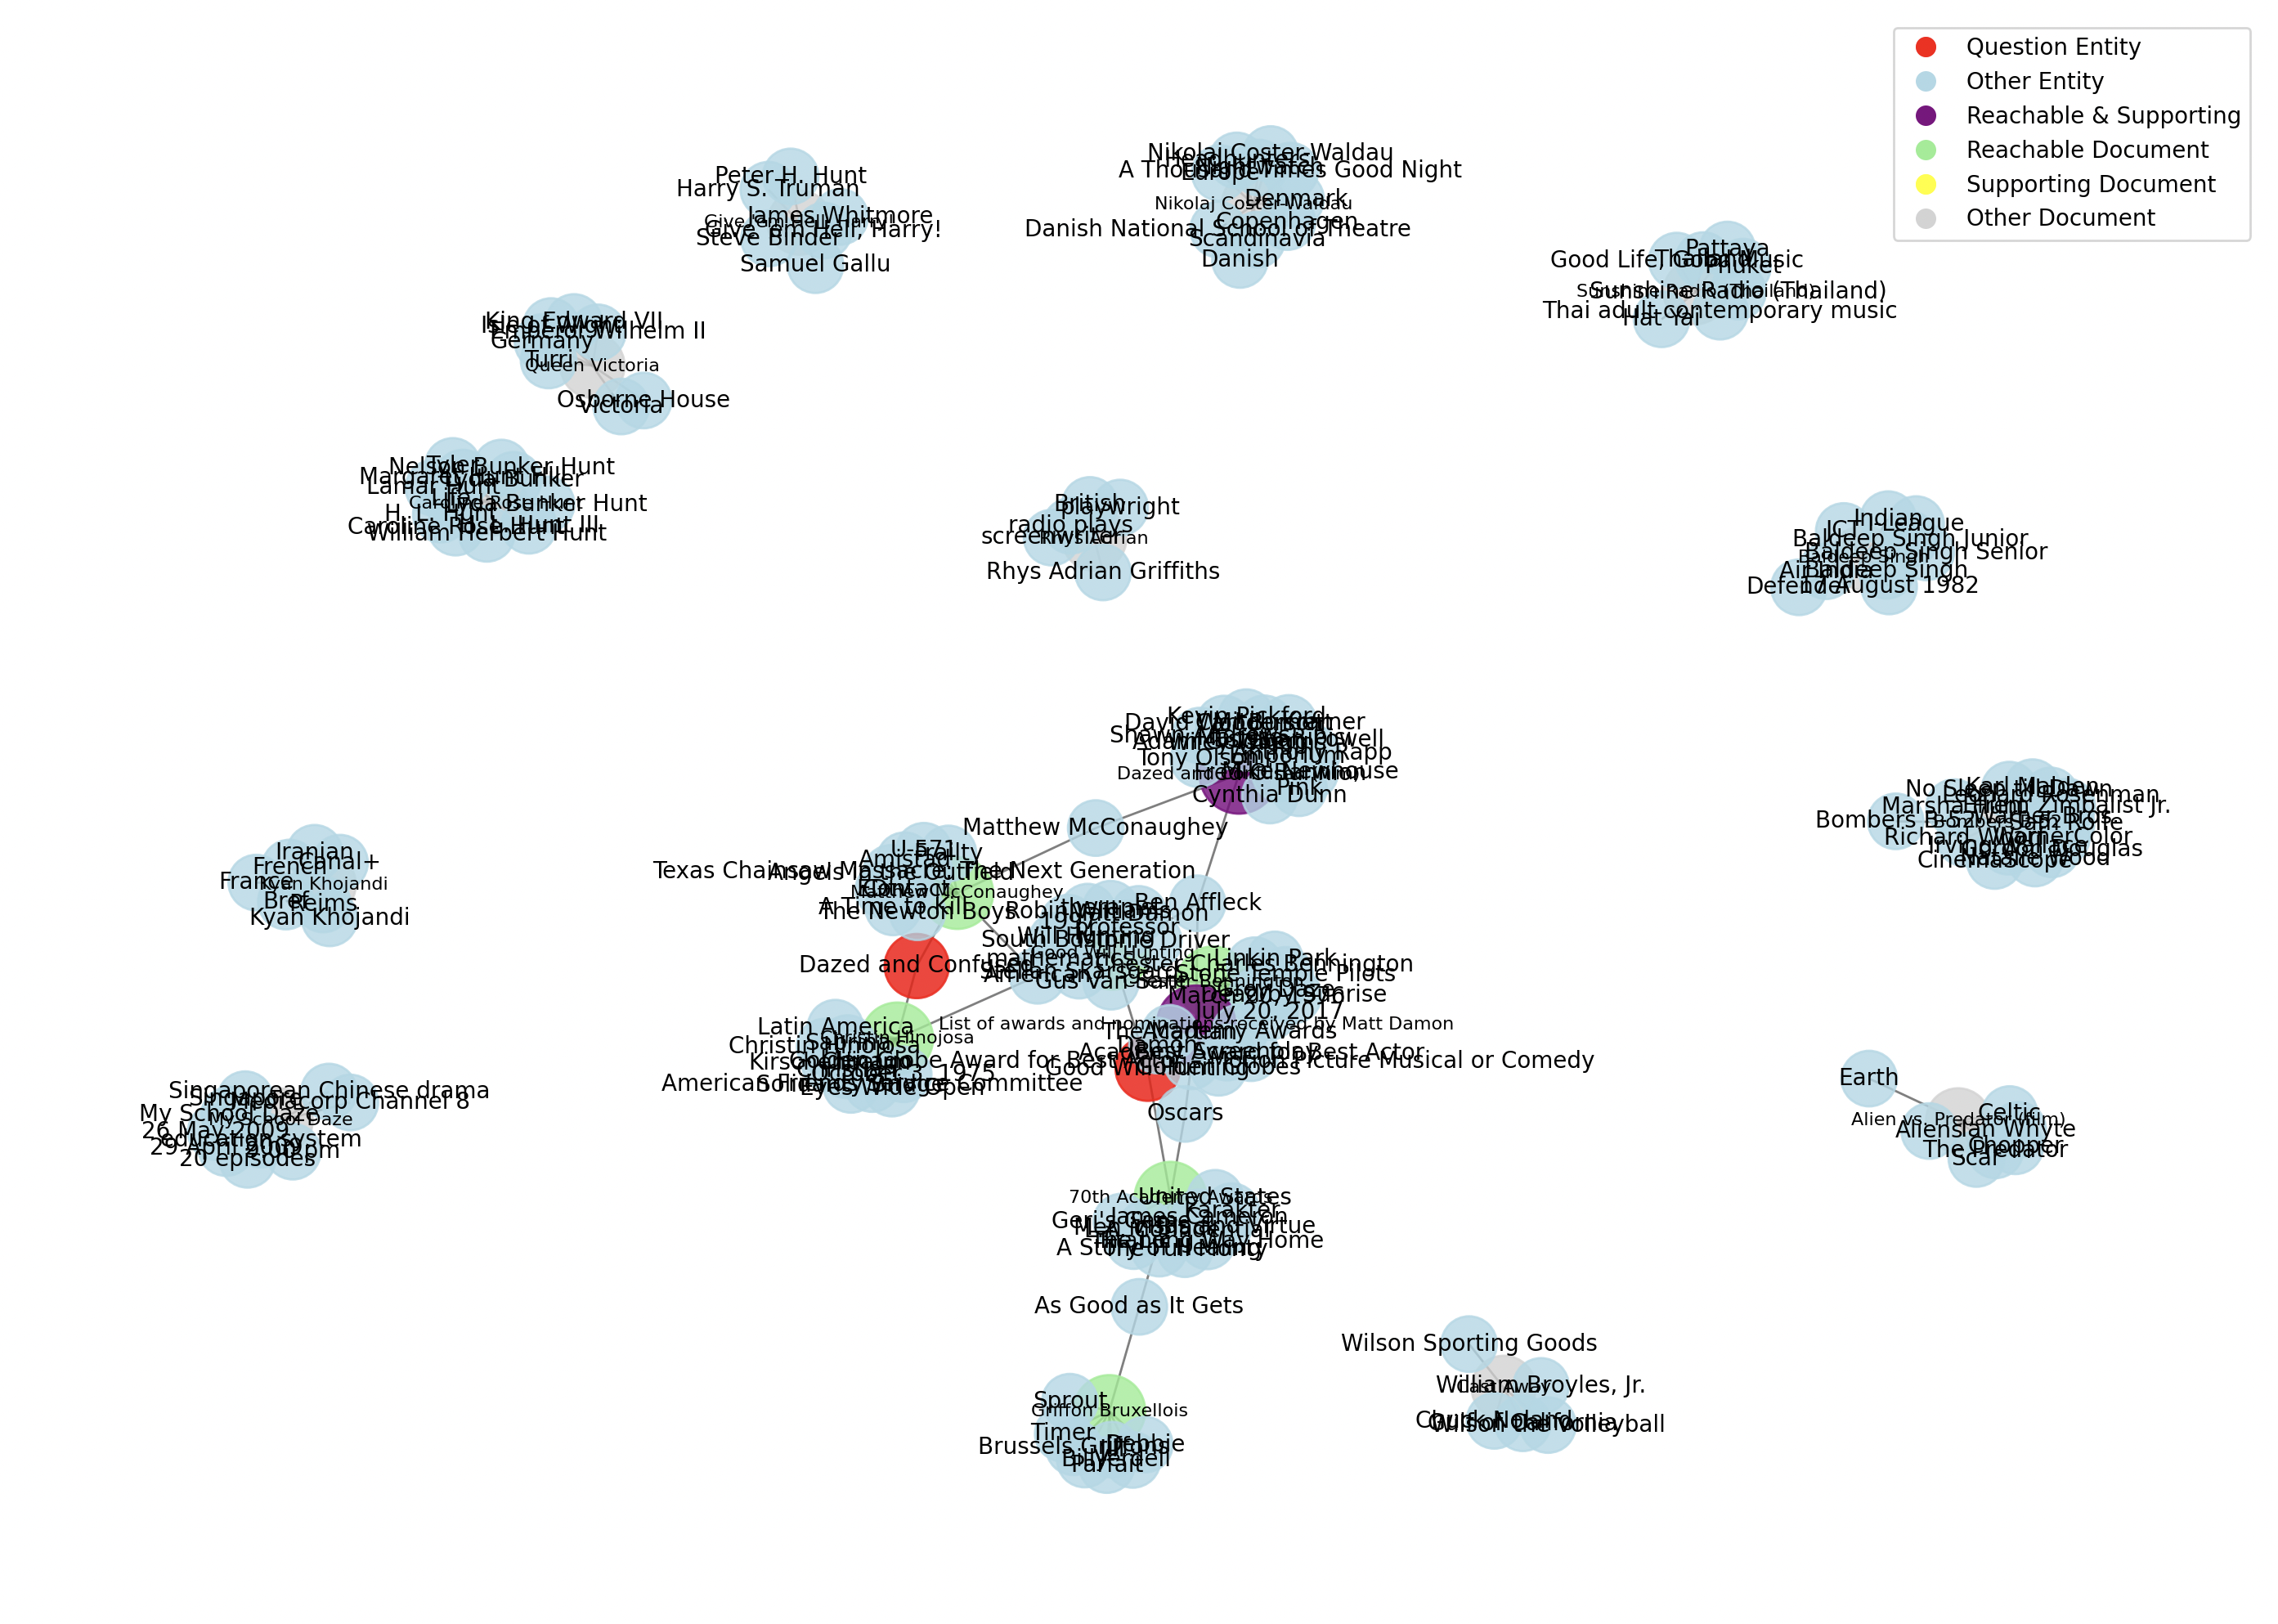


#### Entity-Document Graph (Zoomed)
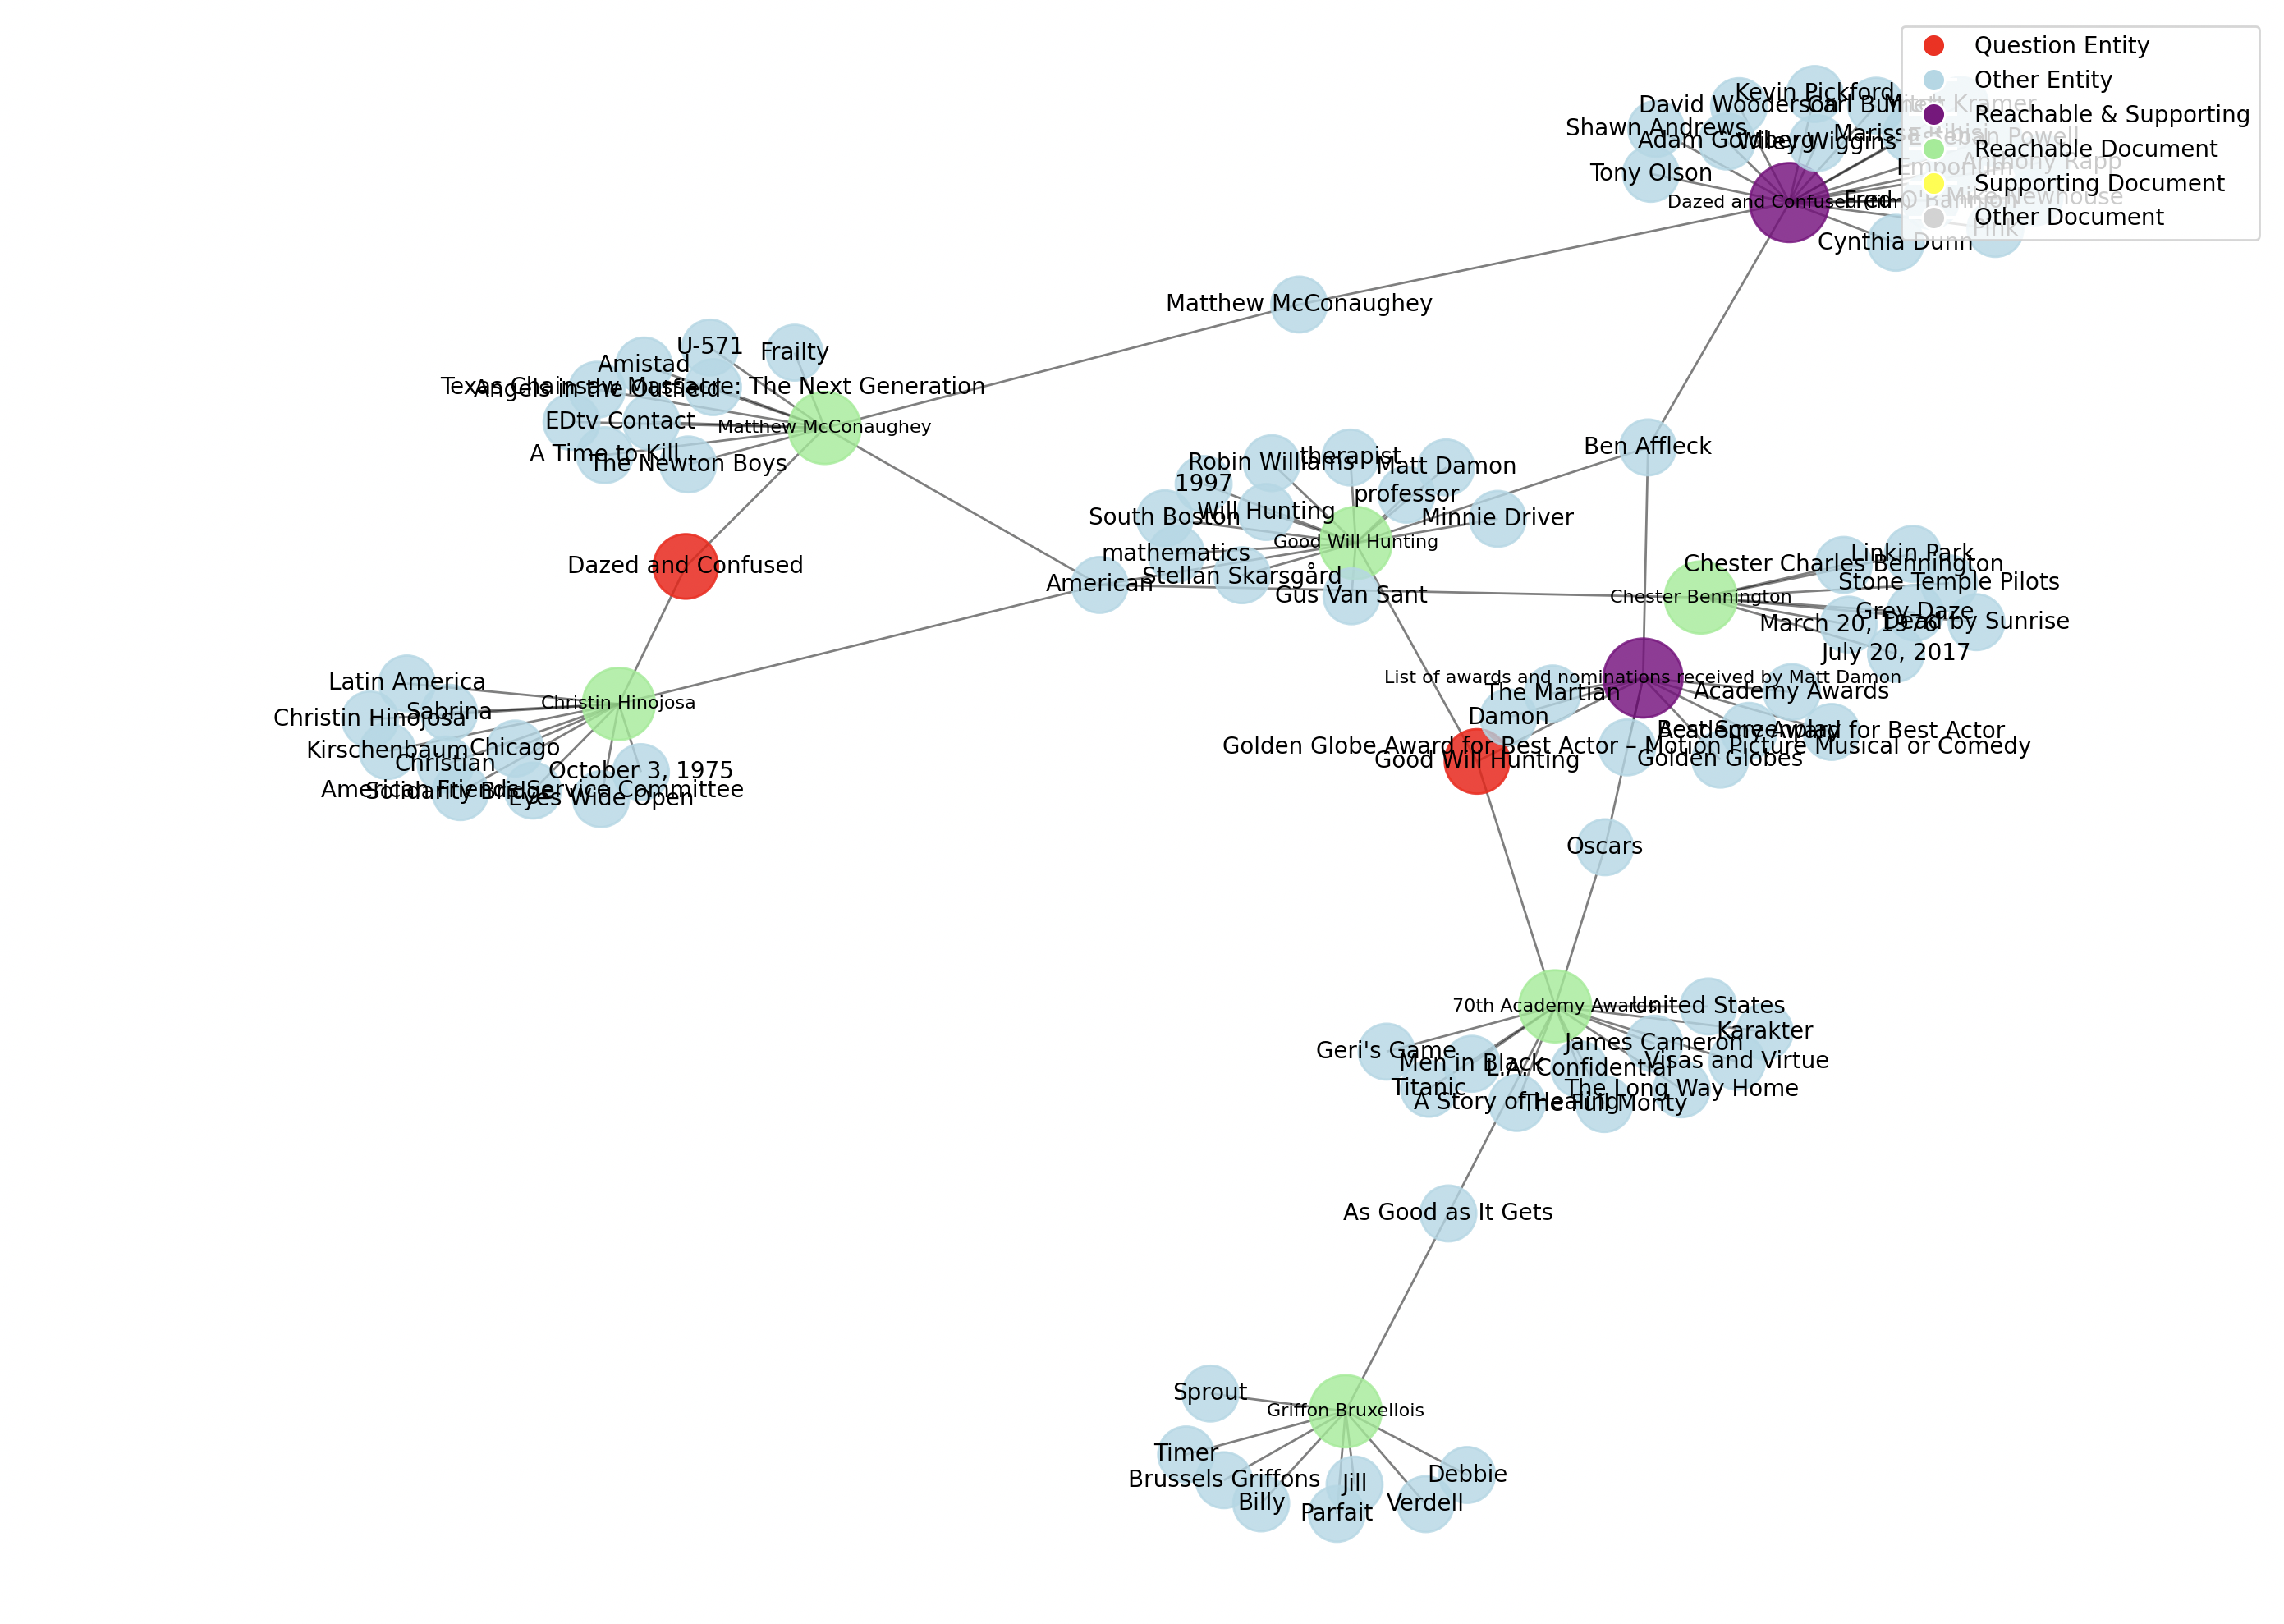

#### Entity Relationship Graph
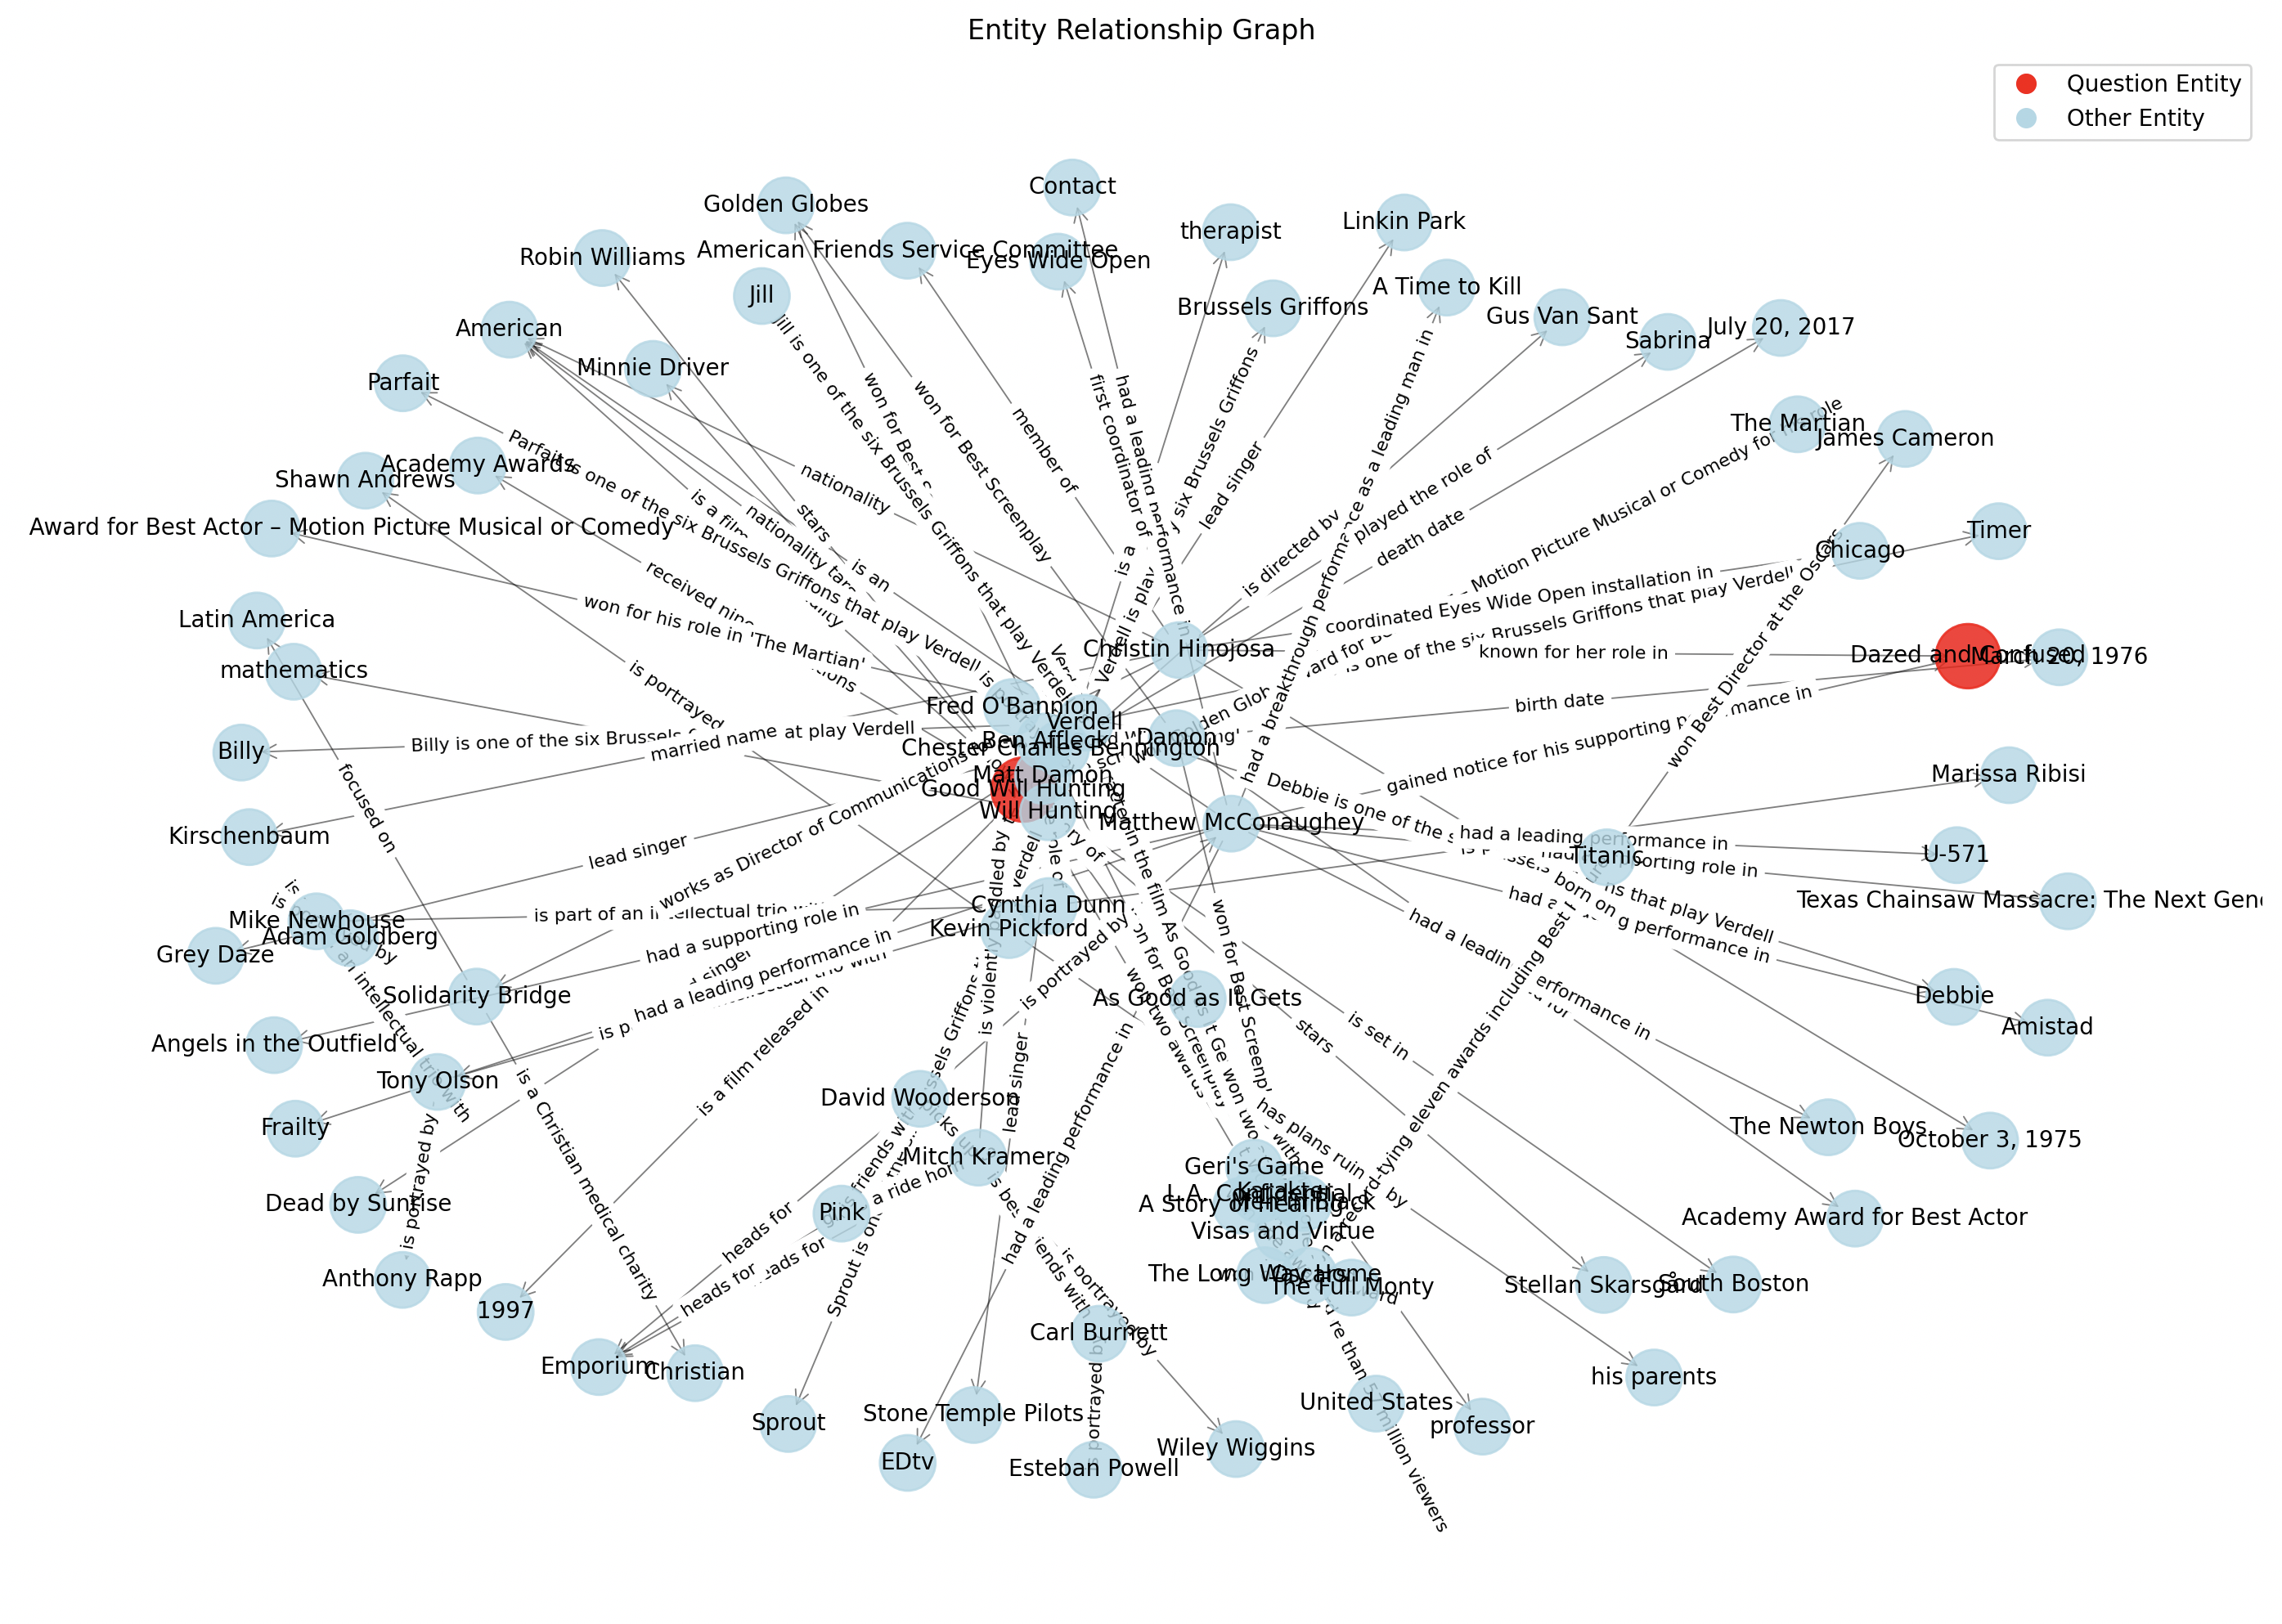